<a href="https://colab.research.google.com/github/FirgiK/Project-NLP-10/blob/main/test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Penjelasan Dataset Yang Digunakan***

### Dataset yang digunakan dalam penelitian ini merupakan kumpulan data teks yang diekstraksi dari platform media sosial X (sebelumnya Twitter), yang berkaitan dengan isu konflik di Palestina. Dataset ini memuat beberapa atribut, antara lain tautan unggahan, isi teks cuitan, identitas pengguna dalam bentuk nama akun, serta indikator interaksi seperti jumlah likes, retweets, quotes, dan comments. Selain itu, dataset turut dilengkapi dengan label klasifikasi yang merepresentasikan kategori sentimen atau posisi opini terhadap konflik yang dimaksud. Penggunaan dataset ini bertujuan untuk menganalisis pola persepsi publik, kecenderungan opini, serta dinamika penyebaran informasi terkait konflik Palestina melalui jejaring media sosial. Dengan demikian, dataset ini relevan sebagai dasar dalam penerapan metode pemrosesan bahasa alami dan analisis sentimen pada penelitian ini.

In [ ]:
!pip install transformers emoji nltk matplotlib seaborn wordcloud

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 8.1 MB/s eta 0:00:00


In [ ]:
# Untuk Pengolahan Kata
from transformers import pipeline
import emoji
import re
import nltk
from nltk.corpus import stopwords, words
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from transformers import pipeline

# Untuk pre processing data
from sklearn.model_selection import train_test_split

# Untuk Pemodelan
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

# Untuk Visualisasi
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import numpy as np
import pandas as pd

import os

# **Data Understanding**

In [ ]:
df = pd.read_csv("./DataSet_for_Bert_7387.csv")

In [ ]:
df.drop_duplicates(inplace=True)
df = df.replace(r'^\s*$', np.nan, regex=True)  # Hapus kolom yang semua nilainya NaN
df

,number,link,text,user,likes,quotes,retweets,comments,label
0,1,https://twitter.com/BabylonBulletin/status/171...,🚨 #BREAKING 🚨 A high-ranking member of Israe...,Babylon Bulletin,2,0,0,0,0
1,2,https://twitter.com/lixi32730051/status/171769...,#BREAKING The #Palestinian Islamic Resistance ...,Journalist Lixy,1,0,0,0,0
2,3,https://twitter.com/ursala_yacoob/status/17176...,"Stop Israel’s atrocities, genocide massacring ...",Ursala Yacoob 🇵🇸🍉,0,0,1,0,1
3,4,https://twitter.com/ellisonbarber/status/17176...,If the walls of #Gaza’s Al Shifa hospital coul...,Ellison Barber,50,4,21,14,1
4,5,https://twitter.com/JohnLocker4/status/1717692...,The people of #Gaza needs to kick #HamasNazis ...,💧John Locker,0,0,0,1,5
...,...,...,...,...,...,...,...,...,...
7382,926,https://twitter.com/iuiccincinnati/status/1803...,Come help #Spread this #Truth to the 4 corners...,IUIC Cincinnati,0,0,0,0,2
7383,986,https://twitter.com/networkparty1/status/18035...,"“Hamas is an idea, #Hamas is a party. It’s roo...",GreenPartyNetwork,0,0,0,0,1
7384,1033,https://twitter.com/PropagandaBuff/status/1803...,#REUTERSPROPAGANDA #Reuters cited this report ...,Dr. Henry Silverman,0,0,0,0,4
7385,1034,https://twitter.com/robertosavard/status/18035...,Hear that great deniers & unconditional defend...,Robert Savard TheMexiCan,0,0,0,0,2


In [ ]:
print(df.isna().sum())
print(df.isnull().sum())
print(df.duplicated().sum())

number      0
link        0
text        0
user        1
likes       0
quotes      0
retweets    0
comments    0
label       0
dtype: int64
number      0
link        0
text        0
user        1
likes       0
quotes      0
retweets    0
comments    0
label       0
dtype: int64
0


In [ ]:
df.dropna(subset=['user'], inplace=True)

# Verifikasi bahwa nilai yang hilang sudah dihilangkan
print(df.isna().sum())

number      0
link        0
text        0
user        0
likes       0
quotes      0
retweets    0
comments    0
label       0
dtype: int64


In [ ]:
# Calculate the character length of the original 'text' column
df['text_length_char'] = df['text'].apply(lambda x: len(str(x)))

# Calculate the character length of the cleaned text column
df['text_cleaned_length_char'] = df['text_cleaned_further'].apply(lambda x: len(str(x)) if x is not None else 0)


# Calculate the average character length for both columns
average_text_length = df['text_length_char'].mean()
average_text_cleaned_length = df['text_cleaned_length_char'].mean()

print(f"Panjang rata-rata karakter pada kolom 'text' (asli): {average_text_length:.2f}")
print(f"Panjang rata-rata karakter pada kolom 'text_cleaned_further' (setelah dibersihkan): {average_text_cleaned_length:.2f}")

# You can also calculate average word count if needed
# df['text_length_word'] = df['text'].apply(lambda x: len(str(x).split()))
# df['text_cleaned_length_word'] = df['text_cleaned_further'].apply(lambda x: len(str(x).split()) if x is not None else 0)
# average_text_word_count = df['text_length_word'].mean()
# average_text_cleaned_word_count = df['text_cleaned_length_word'].mean()
# print(f"Panjang rata-rata kata pada kolom 'text' (asli): {average_text_word_count:.2f}")
# print(f"Panjang rata-rata kata pada kolom 'text_cleaned_further' (setelah dibersihkan): {average_text_cleaned_word_count:.2f}")

Panjang rata-rata karakter pada kolom 'text' (asli): 197.35
Panjang rata-rata karakter pada kolom 'text_cleaned_further' (setelah dibersihkan): 108.94


In [ ]:
# Menggunakan .shape
num_rows_shape = df.shape[0]
print(f"Jumlah baris data menggunakan .shape: {num_rows_shape}")

# Menggunakan len()
num_rows_len = len(df)
print(f"Jumlah baris data menggunakan len(): {num_rows_len}")

Jumlah baris data menggunakan .shape: 7386
Jumlah baris data menggunakan len(): 7386


## **Data Text Processing**

In [ ]:
from nltk.tokenize import word_tokenize

def tokenize_text(text):
    if isinstance(text, str):
        return word_tokenize(text)
    else:
        return [] # Return empty list for non-string data

# Apply tokenization to the 'text_cleaned_further' column
df['text_tokens'] = df['text_cleaned_further'].apply(tokenize_text)

# Display the original text and the new tokens column
print(df[['text_cleaned_further', 'text_tokens']].head())

                                text_cleaned_further  \
0  🚨 🚨 highranking member israeli special forces ...   
1  islamic resistance movement claimed nearly peo...   
2  stop israel ’ atrocities genocide massacring i...   
3  walls ’ al shifa hospital could talk ’ tell st...   
4  people needs kick attacked freaking music fest...   

                                         text_tokens  
0  [🚨, 🚨, highranking, member, israeli, special, ...  
1  [islamic, resistance, movement, claimed, nearl...  
2  [stop, israel, ’, atrocities, genocide, massac...  
3  [walls, ’, al, shifa, hospital, could, talk, ’...  
4  [people, needs, kick, attacked, freaking, musi...  


In [ ]:
from nltk.tokenize import word_tokenize

def tokenize_text(text):
    if isinstance(text, str):
        return word_tokenize(text)
    else:
        return [] # Return empty list for non-string data

# Apply tokenization to the 'text_cleaned_further' column
df['text_tokens'] = df['text_cleaned_further'].apply(tokenize_text)

# Display the original text and the new tokens column
print(df[['text_cleaned_further', 'text_tokens']].head())

                                text_cleaned_further  \
0  highranking member israeli special forces capt...   
1  islamic resistance movement claimed nearly peo...   
2  stop israels atrocities genocide massacring in...   
3  walls al shifa hospital could talk theyd tell ...   
4  people needs kick attacked freaking music fest...   

                                         text_tokens  
0  [highranking, member, israeli, special, forces...  
1  [islamic, resistance, movement, claimed, nearl...  
2  [stop, israels, atrocities, genocide, massacri...  
3  [walls, al, shifa, hospital, could, talk, they...  
4  [people, needs, kick, attacked, freaking, musi...  


In [ ]:
import string
from nltk.corpus import stopwords
import re # Import re for additional character removal

# Download stopwords if not already downloaded
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

# Get English stopwords
stop_words = set(stopwords.words('english'))

# You can add custom stop words here based on your data
custom_stop_words = set([
    # Add your custom words here, e.g., 'kata1', 'kata2', 'dll'
    # Example: 'http', 'https', 'www', 'com', 'twitter', 'status' # Example for social media data
])

# Combine standard and custom stop words
all_stop_words = stop_words.union(custom_stop_words)


def clean_text_further(text):
    if isinstance(text, str):
        # Convert to lowercase
        text = text.lower()

        # Remove specific characters like smart quotes/apostrophes and other non-standard symbols
        # Add more characters here if you notice others in the visualization
        text = text.replace('’', '').replace('‘', '').replace('”', '').replace('“', '')
        text = text.replace("'", "").replace('"', '') # Remove standard quotes/apostrophes too

        # Remove punctuation (this will remove standard punctuation like . , ! ?)
        text = text.translate(str.maketrans('', '', string.punctuation))

        # Remove numbers
        text = re.sub(r'\d+', '', text)

        # Remove stop words
        tokens = word_tokenize(text)
        cleaned_tokens = [word for word in tokens if word not in all_stop_words]

        # Optional: Remove very short tokens (e.g., single characters left after cleaning)
        cleaned_tokens = [word for word in cleaned_tokens if len(word) > 1]


        return ' '.join(cleaned_tokens)
    else:
        return None # Handle non-string data

# Apply the function to the 'text_no_hashtags' column
df['text_cleaned_further'] = df['text_no_hashtags'].apply(clean_text_further)

# Display original and cleaned text
print(df[['text_no_hashtags', 'text_cleaned_further']].head())

                                    text_no_hashtags  \
0  🚨  🚨   A high-ranking member of Israeli specia...   
1  The  Islamic Resistance Movement ( ) claimed t...   
2  Stop Israel’s atrocities, genocide massacring ...   
3  If the walls of ’s Al Shifa hospital could tal...   
4  The people of  needs to kick  out   attacked  ...   

                                text_cleaned_further  
0  highranking member israeli special forces capt...  
1  islamic resistance movement claimed nearly peo...  
2  stop israels atrocities genocide massacring in...  
3  walls al shifa hospital could talk theyd tell ...  
4  people needs kick attacked freaking music fest...  


/tmp/ipython-input-1026561116.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(tokens), palette='viridis')


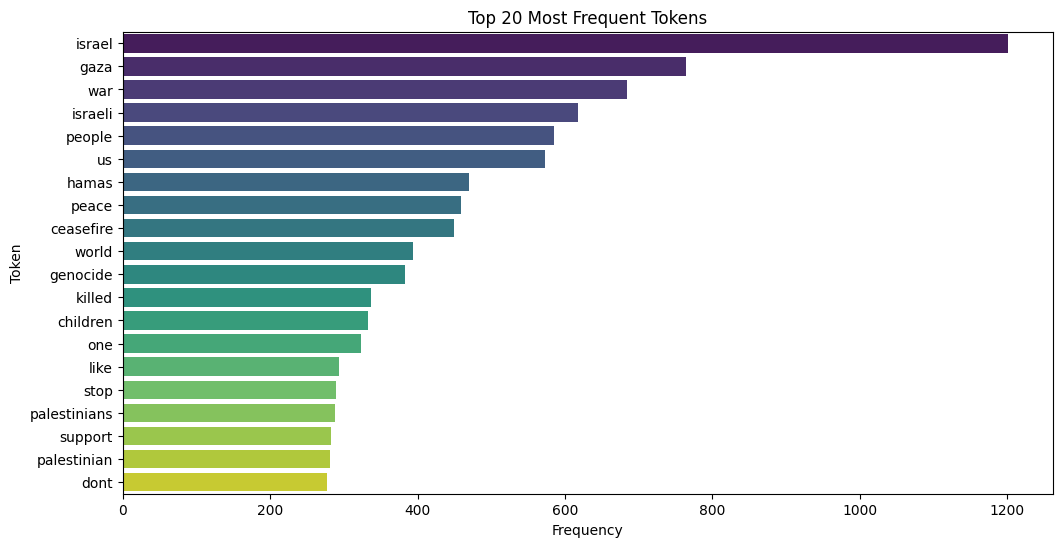

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# Flatten the list of lists in the 'text_tokens' column into a single list of tokens
all_tokens = [token for sublist in df['text_tokens'].dropna() for token in sublist]

# Count the frequency of each token
token_counts = Counter(all_tokens)

# Get the most common tokens (e.g., top 20)
most_common_tokens = token_counts.most_common(20)

# Prepare data for plotting
tokens, counts = zip(*most_common_tokens)

# Create a bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x=list(counts), y=list(tokens), palette='viridis')
plt.title('Top 20 Most Frequent Tokens')
plt.xlabel('Frequency')
plt.ylabel('Token')
plt.show()

In [ ]:
from nltk.stem import WordNetLemmatizer
# WordNetLemmatizer requires the WordNet corpus
try:
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('wordnet')

# Initialize the WordNet Lemmatizer
lemmatizer = WordNetLemmatizer()

def lemmatize_tokens(tokens):
    if isinstance(tokens, list):
        # Lemmatize each token
        # Default POS is noun (n), you might get better results by specifying POS (e.g., pos='v' for verbs)
        # using POS tagging, but that adds complexity.
        lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
        return lemmatized_tokens
    else:
        return [] # Handle non-list data

# Apply lemmatization to the 'text_tokens' column
df['text_lemmatized'] = df['text_tokens'].apply(lemmatize_tokens)

# Display original tokens and the new lemmatized tokens column
print(df[['text_tokens', 'text_lemmatized']].head())

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


                                         text_tokens  \
0  [highranking, member, israeli, special, forces...   
1  [islamic, resistance, movement, claimed, nearl...   
2  [stop, israels, atrocities, genocide, massacri...   
3  [walls, al, shifa, hospital, could, talk, they...   
4  [people, needs, kick, attacked, freaking, musi...   

                                     text_lemmatized  
0  [highranking, member, israeli, special, force,...  
1  [islamic, resistance, movement, claimed, nearl...  
2  [stop, israel, atrocity, genocide, massacring,...  
3  [wall, al, shifa, hospital, could, talk, theyd...  
4  [people, need, kick, attacked, freaking, music...  


In [ ]:
from nltk.stem import PorterStemmer

# Initialize the Porter Stemmer
porter = PorterStemmer()

def stem_tokens(tokens):
    if isinstance(tokens, list):
        # Stem each token
        stemmed_tokens = [porter.stem(token) for token in tokens]
        return stemmed_tokens
    else:
        return [] # Handle non-list data

# Apply stemming to the 'text_tokens' column
df['text_stemmed'] = df['text_tokens'].apply(stem_tokens)

# Display original tokens, lemmatized tokens, and the new stemmed tokens column
print(df[['text_tokens', 'text_lemmatized', 'text_stemmed']].head())

                                         text_tokens  \
0  [highranking, member, israeli, special, forces...   
1  [islamic, resistance, movement, claimed, nearl...   
2  [stop, israels, atrocities, genocide, massacri...   
3  [walls, al, shifa, hospital, could, talk, they...   
4  [people, needs, kick, attacked, freaking, musi...   

                                     text_lemmatized  \
0  [highranking, member, israeli, special, force,...   
1  [islamic, resistance, movement, claimed, nearl...   
2  [stop, israel, atrocity, genocide, massacring,...   
3  [wall, al, shifa, hospital, could, talk, theyd...   
4  [people, need, kick, attacked, freaking, music...   

                                        text_stemmed  
0  [highrank, member, isra, special, forc, captur...  
1  [islam, resist, movement, claim, nearli, peopl...  
2  [stop, israel, atroc, genocid, massacr, innoc,...  
3  [wall, al, shifa, hospit, could, talk, theyd, ...  
4  [peopl, need, kick, attack, freak, music, fest..

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# Pilih kolom teks yang akan digunakan (misal: text_cleaned_further) dan kolom label sentimen
X = df['text_cleaned_further'].dropna() # Drop NA just in case, although we handled it
y = df.loc[X.index, 'Sentiment'] # Ensure labels correspond to the cleaned text indices

# Drop rows where 'Sentiment' is None
non_none_sentiment_indices = y.dropna().index
X = X.loc[non_none_sentiment_indices]
y = y.loc[non_none_sentiment_indices]


# Bagi data menjadi set pelatihan dan pengujian
# test_size=0.2 berarti 20% data untuk pengujian, random_state untuk reproduktivitas
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) # Stratify to maintain sentiment distribution


# Inisialisasi TfidfVectorizer
# max_features bisa disesuaikan untuk membatasi jumlah fitur (kata)
tfidf_vectorizer = TfidfVectorizer(max_features=5000) # Example: consider top 5000 words

# Latih vectorizer pada data pelatihan dan transformasikan data pelatihan
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Transformasikan data pengujian menggunakan vectorizer yang sudah dilatih
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print("Shape data pelatihan (TF-IDF):", X_train_tfidf.shape)
print("Shape data pengujian (TF-IDF):", X_test_tfidf.shape)

Shape data pelatihan (TF-IDF): (5877, 5000)
Shape data pengujian (TF-IDF): (1470, 5000)


In [ ]:
# Get the feature names (words) from the vectorizer
feature_names = tfidf_vectorizer.get_feature_names_out()

# Select a sample document from the training set (e.g., the first document)
sample_document_tfidf = X_train_tfidf[0]

# Get the TF-IDF scores for the sample document
# .toarray() converts the sparse matrix row to a dense numpy array
scores = sample_document_tfidf.toarray()[0] # Use .toarray() instead of .A

# Create a list of (word, score) tuples
word_score_pairs = list(zip(feature_names, scores))

# Sort the pairs by score in descending order
word_score_pairs_sorted = sorted(word_score_pairs, key=lambda x: x[1], reverse=True)

# Display the top N words with highest TF-IDF scores for this document (e.g., top 10)
print("Top 10 kata dengan skor TF-IDF tertinggi di dokumen pertama set pelatihan:")
for word, score in word_score_pairs_sorted[:10]:
    print(f"{word}: {score:.4f}")

# You can also see the total number of features learned
print(f"\nTotal jumlah fitur (kata unik) yang dipelajari: {len(feature_names)}")

# Display a few random feature names
import random
print("\nBeberapa contoh fitur (kata) yang dipelajari:")
print(random.sample(list(feature_names), 20))

Top 10 kata dengan skor TF-IDF tertinggi di dokumen pertama set pelatihan:
foundation: 0.8071
terrorism: 0.5905
ab: 0.0000
abaerbock: 0.0000
abandon: 0.0000
abbas: 0.0000
abc: 0.0000
abcnews: 0.0000
abdel: 0.0000
abdullah: 0.0000

Total jumlah fitur (kata unik) yang dipelajari: 5000

Beberapa contoh fitur (kata) yang dipelajari:
['nk', 'choose', 'excuse', 'another', 'happen', 'homes', 'flour', 'hiroshima', 'ep', 'operations', 'reasonable', 'stream', 'learned', 'ya', 'school', 'incursion', 'genocide', 'crossing', 'lines', 'gold']


# **Data Modeling**